# Model Analysis

**Create exploratory plots & statistics of the model.**

Specifically we measure rewards of games (aka episodes) played by 2 models:
- The greedy model always chooses the best action (ε=0)
- The exploration model takes a random action with a 10% chance (ε=0.1).

We measure the median reward of multiple models, to limit the influence of randomness.

## Overview

* Setup
* Train & Test the models
* Reward during training progress
* Reward of fully trained models
* Time Metrics


## Setup

In [1]:
import time
import warnings
from random import Random

import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

from classes.action import Action
from classes.game import Game
from classes.model import ModelRLMC
from classes.state import State
from classes.utils import get_track

In [2]:
sns.set_theme()

## Train & test the models

Define some functions.

In [3]:
def get_reward_of_episode(episode: list[tuple[State, Action, int]]) -> int:
    total_reward = 0
    for (state, action, reward) in episode:
        total_reward += reward
    return total_reward

In [4]:
def simulate_train(track: np.ndarray, epsilon: float, n_models: int = 10, n_episodes: int = 1000) -> tuple[pd.DataFrame, np.ndarray, list[ModelRLMC]]:
    """
    Trains multiple models, and collect statistics of their games
    """
    
    # generate list of random states, so that each model starts with different & reproducible seeds
    rnd = Random(42)
    random_states = [rnd.randint(0, 100000000) for _ in range(n_models)]

    train_times = np.zeros(n_models)
    stats_per_game_and_model: list[tuple[int, int, int, int]] = [] # dimensions: n_model, n_game, n_steps, reward
    models: list[ModelRLMC] = []

    for i in range(n_models):
        model = ModelRLMC(random_state=random_states[i])
        game = Game(racetrack=track, random_state=random_states[i])
        start = time.time()
        for j in range(0, n_episodes):
            episode: list[tuple[State, Action, int]] = []
            while not game.is_finished() and game.get_n_steps() < 1000:
                state = game.get_state()
                action = model.determine_epsilon_action(state, epsilon)
                reward = game.noisy_step(action)
                episode.append((state, action, reward))
            model.learn(episode)
            game.reset()

            total_reward = get_reward_of_episode(episode)
            stats_per_game_and_model.append((i,j,game.get_n_steps(),total_reward))
        end = time.time()
        train_times[i] = end - start
        models.append(model)

    df = pd.DataFrame(stats_per_game_and_model, columns=["n_model","n_games","n_steps","reward"])
    df["epsilon"] = epsilon
    return df, train_times, models

In [5]:
def simulate_test(track: np.ndarray, models: list[ModelRLMC], epsilon: float, n_episodes: int = 100) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Tests multiple trained models, and collect statistics of their games
    """

    # generate list of random states
    rnd = Random(43)
    random_states = [rnd.randint(0, 100000000) for _ in range(len(models))]

    test_times = np.zeros(shape=(len(models),n_episodes))
    stats_per_game_and_model: list[tuple[int, int, int, int]] = [] # dimensions:  n_game, n_steps, reward

    for i, model in enumerate(models):
        game = Game(racetrack=track, random_state=random_states[i])
        for j in range(0, n_episodes):
            start = time.time()
            episode: list[tuple[State, Action, int]] = []
            while not game.is_finished() and game.get_n_steps() < 1000:
                state = game.get_state()
                action = model.determine_best_action(state)
                reward = game.step(action)
                episode.append((state, action, reward))
            game.reset()
            total_reward = get_reward_of_episode(episode)
            stats_per_game_and_model.append((i,j,game.get_n_steps(),total_reward))
            end = time.time()
            test_times[i][j] = end - start

    df = pd.DataFrame(stats_per_game_and_model, columns=["n_model","n_games","n_steps","reward"])
    df["epsilon"] = epsilon
    return df, test_times

In [6]:
def lowess_grouped(data: pd.DataFrame, x_name: str | tuple[str,...], y_name: str | tuple[str,...], group_name: str | tuple[str,...] | None, frac: float) -> pd.DataFrame:
    """
    Apply groupwise lowess smoothing to a dataframe
    """

    df = data.copy()

    if type(y_name) is str:
        y_name_smoothed = y_name + "_smooth"
    elif type(y_name) is tuple:
        y_name_smoothed = (y_name[0]+"_smooth",) + (y_name[1:])
    else:
        raise ValueError("Type of y_name not supported")

    if group_name is not None:
        groups = df[group_name].unique().tolist()
        smoothed_dfs = []
        for group in groups:
            df_by_select_group = df[df[group_name] == group]
            smoothed_df = lowess(df_by_select_group[y_name],df_by_select_group[x_name], frac=frac)
            smoothed_df = pd.DataFrame(smoothed_df, columns=[x_name, y_name_smoothed])
            smoothed_df[group_name] = group
            smoothed_dfs.append(smoothed_df)
        return pd.merge(df,pd.concat(smoothed_dfs), how="left", on=[x_name,group_name])
    else:
        smoothed_df = lowess(df[y_name], df[x_name], frac=frac)
        smoothed_df = pd.DataFrame(smoothed_df, columns=[x_name, y_name_smoothed])
        return pd.merge(df,smoothed_df, how="left", on=x_name)

Select the racetrack.

In [7]:
track = get_track(track_number=None, track_random_seed=81)

Train and test models using epsilon of 0% and 10%.

In [8]:
stats_train_e0, train_times_e0, models_e0 = simulate_train(track, epsilon=0, n_models=3, n_episodes=50000)
stats_train_e10, train_times_e10, models_e10 = simulate_train(track, epsilon=0.1, n_models=3, n_episodes=50000)

In [9]:
stats_test_e0, test_times_e0 = simulate_test(track, models_e0, epsilon=0)
stats_test_e10, test_times_e10 = simulate_test(track, models_e10, epsilon=0.1)

Aggregate and smooth train and test data

In [10]:
# ignore warnings from function lowess_grouped()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    stats_test = pd.concat([stats_test_e0,stats_test_e10])
    stats_test = stats_test.groupby(["epsilon","n_games"]).aggregate({'reward':['median','min','max']}).reset_index()
    stats_test = lowess_grouped(stats_test, y_name=("reward","median"), x_name=("n_games",""), group_name="epsilon", frac=0.07)
    stats_test = lowess_grouped(stats_test, y_name=("reward","min"), x_name=("n_games",""), group_name="epsilon", frac=0.07)
    stats_test = lowess_grouped(stats_test, y_name=("reward","max"), x_name=("n_games",""), group_name="epsilon", frac=0.07)

    stats_train = pd.concat([stats_train_e0,stats_train_e10])
    stats_train = stats_train.groupby(["epsilon","n_games"]).aggregate({'reward':['median','min','max']}).reset_index()
    stats_train = lowess_grouped(stats_train, y_name=("reward","median"), x_name=("n_games",""), group_name="epsilon", frac=0.07)
    stats_train = lowess_grouped(stats_train, y_name=("reward","min"), x_name=("n_games",""), group_name="epsilon", frac=0.07)
    stats_train = lowess_grouped(stats_train, y_name=("reward","max"), x_name=("n_games",""), group_name="epsilon", frac=0.07)

## Reward during training progress

Let's look how the reward (aka performance) of the models change, as we train them for more episodes

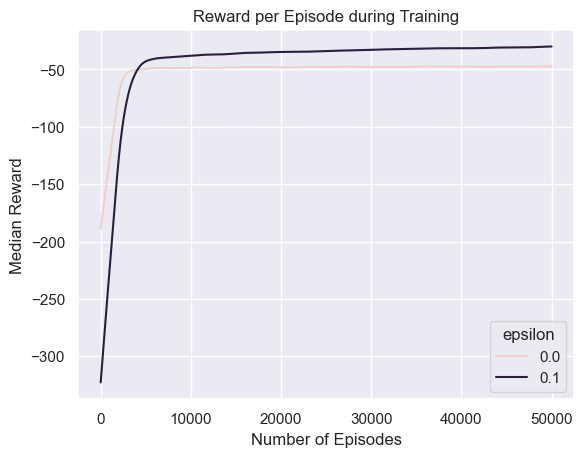

In [16]:
g = sns.lineplot(stats_train,x=("n_games",""),y=("reward_smooth","median"),hue="epsilon")
g.set(title='Reward per Episode during Training', xlabel='Number of Episodes', ylabel='Median Reward');

## Reward of fully trained models

Let's look how the reward of the trained models compares.

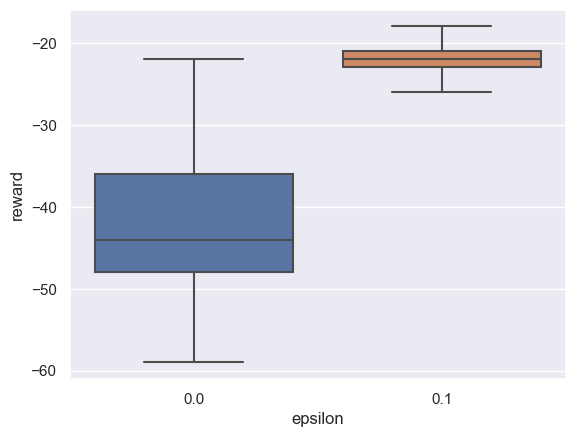

In [11]:
sns.boxplot(pd.concat([stats_test_e0,stats_test_e10]), x="epsilon", y="reward", showfliers=False);

Show outliners in boxplot

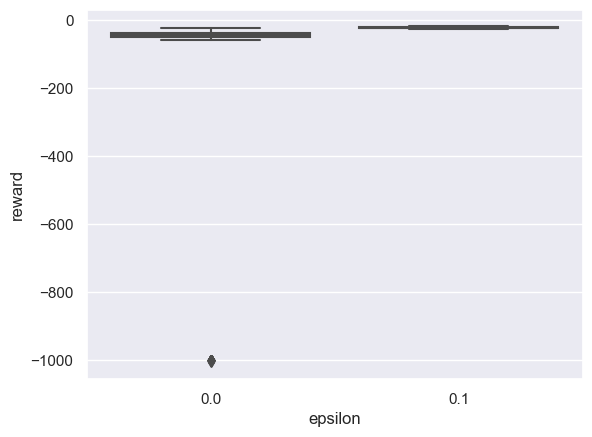

In [12]:
sns.boxplot(pd.concat([stats_test_e0,stats_test_e10]), x="epsilon", y="reward", showfliers=True);

In some cases violinplots can help understanding the distribution better.

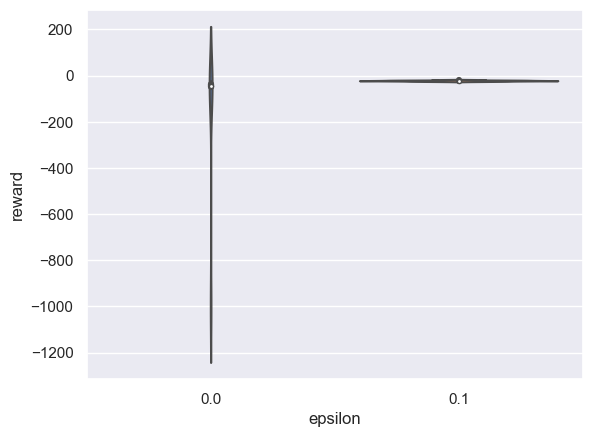

In [13]:
sns.violinplot(pd.concat([stats_test_e0,stats_test_e10]), x="epsilon", y="reward");

## Time Metrics

Training Times

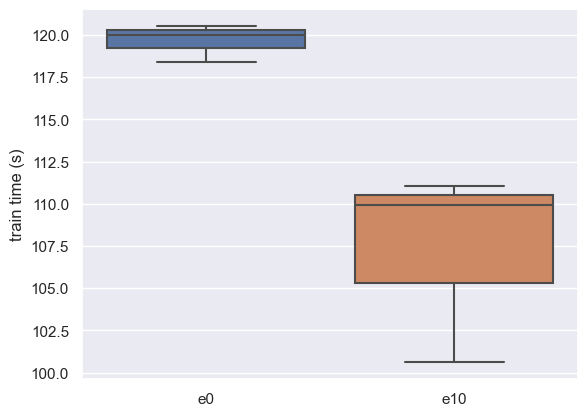

In [14]:
train_times = pd.DataFrame({"e0": train_times_e0, "e10": train_times_e10})
sns.boxplot(train_times).set(ylabel="train time (s)");

Testing Times

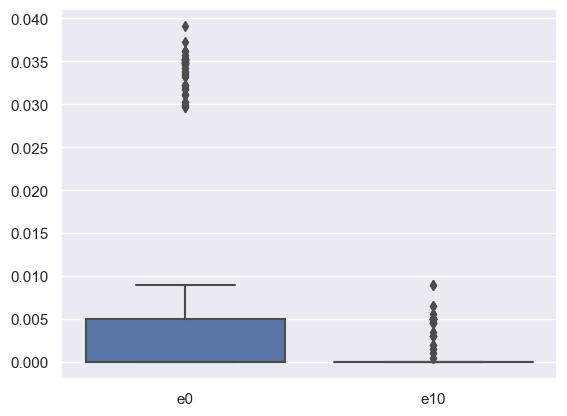

In [15]:
test_times = pd.DataFrame({"e0": test_times_e0.flatten(), "e10": test_times_e10.flatten()})
sns.boxplot(test_times);